In [78]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import tqdm

In [13]:
datadir = '../../datasets/foldtree2/'

In [14]:

#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )


reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [15]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [16]:
#make a structure alignment directory
if not os.path.exists( 'struct_align' ):
    os.makedirs( 'struct_align' )

#make a directory for each cluster representative
for rep in reps['repId']:
    if not os.path.exists( datadir +'struct_align/' + rep  ):
        os.makedirs(datadir + 'struct_align/' + rep  )
    if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
        os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
        

KeyboardInterrupt: 

In [17]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [18]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [79]:
import foldtree2_ecddcd as ft2
import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)

ndim = 844
converter = ft2.PDB2PyG()

with open( 'model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )

#use the encoder to make a fasta file
#encoder = ft2.HeteroGAE_Encoder(in_channels=ndim, hidden_channels=[ 400 ]*3 , out_channels=250, metadata=converter.metadata , num_embeddings=248, commitment_cost=1 , encoder_hidden=500 , EMA = True , reset_codes = False )
#encoder_save = 'encoder_mk2_aa_50_AAq_transformermk3_248'
#encoder.load_state_dict( torch.load( encoder_save ) )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
encoder.eval()


['families/fsx1/6EGU.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/1OAN.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/4HJ1.pdb']


HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): SAGEConv(844, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(844, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(844, 400, aggr=mean)
      (res_hbond_res): SAGEConv(844, 400, aggr=mean)
    )
    (1-2): 2 x ModuleDict(
      (res_backbone_res): SAGEConv(400, 400, aggr=mean)
      (res_backbonerev_res): SAGEConv(400, 400, aggr=mean)
      (res_contactPoints_res): SAGEConv(400, 400, aggr=mean)
      (res_hbond_res): SAGEConv(400, 400, aggr=mean)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (out_dense): Sequential(
    (0): Linear(in_features=420, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): Tanh()
  )
  (vector_quantizer): VectorQuantizerE

In [81]:

import importlib
importlib.reload(ft2)
from torch_geometric.data import DataLoader

struct_dat = ft2.StructureDataset('structs_structalign_new.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encoder.eval()

encode_alns = False
if encode_alns == True:
        
    def databatch2list(loader):
        for data in loader:
            data = data.to_data_list()
            for d in data:
                yield d
    encoder_loader = databatch2list(encoder_loader)
    encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )

12530it [04:38, 45.06it/s]


In [92]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )
print(encoded_df)

25060it [00:00, 350271.96it/s]

                                                          seq
protid                                                       
A0A6M3X4H4  66íí¿íí·N*ùí·*Àa2üMíí?@\@ë*?ë...
A0A328EIH0  66Oeý8/](]ýEE(OcüOCI(ICbR?íc*...
A0A2T6BQ81  61cíb$:(O]üÀ5G8ícíí·b%ùOcÀ2ÀFOO1ý:ü]...
A0A2M8HS09  66/$ý:G5((88e/(/:/EEü4·O/Àe...
A0A6P8Y804  66/:8Eà/85/O4/8/]àE/E5E//(4ýE"...
...                                                       ...
A0A254UVH7  66COù·8·C·Cbík\ë@$ùI8ùI$CC?...
D2R7F1      66I6CC/C8cCCbcmCCüC4ù5F]eà]]E4eI...
A0A1G8L9L0  11ccùmíc?ícm*pÀü2A:He((e/I8(8Hý...
S2VXX2      168càü?Ic*IùCIcCcc$CH$OH854...
A0A7X8IYP6  66C$à]66OeG84]]:O:GCOeýý...

[12529 rows x 1 columns]


In [93]:
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A6M3X4H4  66íí¿íí·N*ùí·*Àa2üMíí?@\@ë*?ë...   
A0A328EIH0  66Oeý8/](]ýEE(OcüOCI(ICbR?íc*...   
A0A2T6BQ81  61cíb$:(O]üÀ5G8ícíí·b%ùOcÀ2ÀFOO1ý:ü]...   
A0A2M8HS09  66/$ý:G5((88e/(/:/EEü4·O/Àe...   
A0A6P8Y804  66/:8Eà/85/O4/8/]àE/E5E//(4ýE"...   

                                                          ord  \
protid                                                          
A0A6M3X4H4  [54, 54, 237, 29, 237, 191, 237, 237, 30, 183,...   
A0A328EIH0  [54, 54, 79, 101, 133, 29, 21, 253, 17, 56, 47...   
A0A2T6BQ81  [54, 49, 99, 237, 98, 36, 29, 58, 40, 15, 79, ...   
A0A2M8HS09  [54, 54, 47, 36, 29, 30, 6, 21, 127, 253, 21, ...   
A0A6P8Y804  [54, 54, 47, 58, 6, 56, 69, 224, 29, 47, 21, 5...   

                                                         hex2  
protid                  

In [94]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
    char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )

['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'y', '|', '\x7f', '\x80', '\x82', '\x85', '\x86', '\x88', '\x8c', '\x91', '\x92', '\x9a', '¥', 'µ', '·', '¿', 'À', 'Á', 'Ã', 'Í', 'Î', 'Ô', 'Õ', '×', 'Ø', 'Þ', 'à', 'â', 'å', 'æ', 'ç', 'ë', 'ì', 'í', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ']
149


In [95]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
replace_dict = { '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
for i in range( 1,charset ):
    #print hex and ascii
    char = chr(i) if chr(i) not in replace_dict.keys() else replace_dict[ chr(i) ]
    print( ord(char), char ,  hex(i) )


1  0x1
2  0x2
3  0x3
4  0x4
5  0x5
6  0x6
7  0x7
8 0x8
9 	 0x9
255 ÿ 0xa
11  0xb
12  0xc
254 þ 0xd
14  0xe
15  0xf
16  0x10
17  0x11
18  0x12
19  0x13
20  0x14
21  0x15
22  0x16
23  0x17
24  0x18
25  0x19
26  0x1a
27  0x1b
28  0x1c
29  0x1d
30  0x1e
31  0x1f
253 ý 0x20
33 ! 0x21
34 " 0x22
35 # 0x23
36 $ 0x24
37 % 0x25
38 & 0x26
39 ' 0x27
40 ( 0x28
41 ) 0x29
42 * 0x2a
43 + 0x2b
44 , 0x2c
252 ü 0x2d
46 . 0x2e
47 / 0x2f
48 0 0x30
49 1 0x31
50 2 0x32
51 3 0x33
52 4 0x34
53 5 0x35
54 6 0x36
55 7 0x37
56 8 0x38
57 9 0x39
58 : 0x3a
59 ; 0x3b
251 û 0x3c
250 ú 0x3d
249 ù 0x3e
63 ? 0x3f
64 @ 0x40
65 A 0x41
66 B 0x42
67 C 0x43
68 D 0x44
69 E 0x45
70 F 0x46
71 G 0x47
72 H 0x48
73 I 0x49
74 J 0x4a
75 K 0x4b
76 L 0x4c
77 M 0x4d
78 N 0x4e
79 O 0x4f
80 P 0x50
81 Q 0x51
82 R 0x52
83 S 0x53
84 T 0x54
85 U 0x55
86 V 0x56
87 W 0x57
88 X 0x58
89 Y 0x59
90 Z 0x5a
91 [ 0x5b
92 \ 0x5c
93 ] 0x5d
94 ^ 0x5e
95 _ 0x5f
96 ` 0x60
97 a 0x61
98 b 0x62
99 c 0x63
100 d 0x64
101 e 0x65
102 f 0

In [85]:

cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')

fident_thresh = .3

submat =  np.zeros((256,256))

background_freq = np.zeros(256)

q_mat = np.zeros((256,256))

seqcount = 0
for rep in tqdm.tqdm(alnfiles ):

    q_mat_chunk = np.zeros((256,256))
    submat_chunk = np.zeros((256,256))
    alncount = 0
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    
    seqset = set()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
                    aln = aln.iloc[0]
                    qaln = aln.qaln
                    taln = aln.taln
                    qaccession = q.split( '.' )[0]
                    taccession = t.split( '.' )[0]

                    if qaccession in encoded_df.index and taccession in encoded_df.index:
                        qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
                        tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

                        if qaccession not in seqset:
                            background_freq += np.array([ qz.count( chr(i) ) for i in range(256) ])
                            seqset.add( qaccession )
                            seqcount += len(qz)
                        
                        if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
                            qz = iter(qz)
                            tz = iter(tz)

                            #transfer the alignments to the embeddings                    
                            qaln_ft2, taln_ft2 = [], []

                            for q_char in qaln:
                                if q_char == '-':
                                    qaln_ft2.append(None)
                                else:
                                    qaln_ft2.append(ord(next(qz)))
                                   
                            for t_char in taln.strip():
                                if t_char == '-':
                                    taln_ft2.append(None)
                                else:
                                    taln_ft2.append(ord(next(tz)))

                            alnzip = list(zip( qaln_ft2 , taln_ft2 ))
                            alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
                            #normalize by size of alignment
                            
                            submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
                            #normalize by size of alignment and number of pairs
                            alncount += 1
                            q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
        if alncount > 0:
            q_mat += (q_mat_chunk / alncount)
            submat += (submat_chunk / alncount)



100%|████████████████████████████████████████████████████████████████████████████| 3691/3691 [00:46<00:00, 80.07it/s]


In [86]:
from matplotlib import pyplot as plt

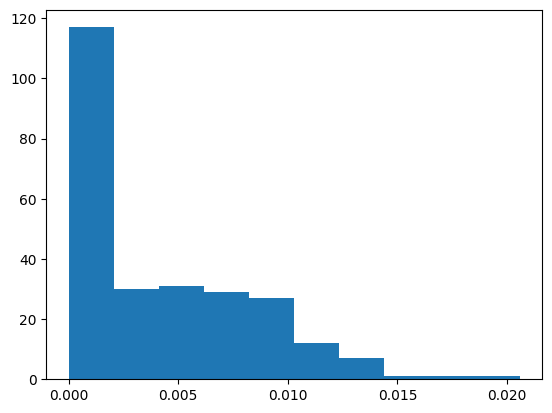

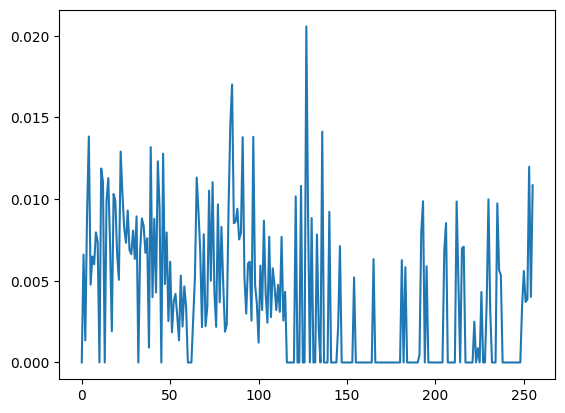

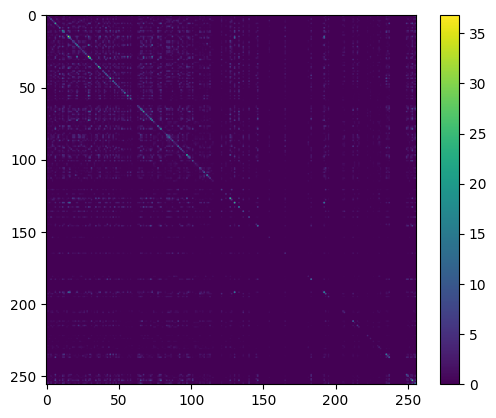

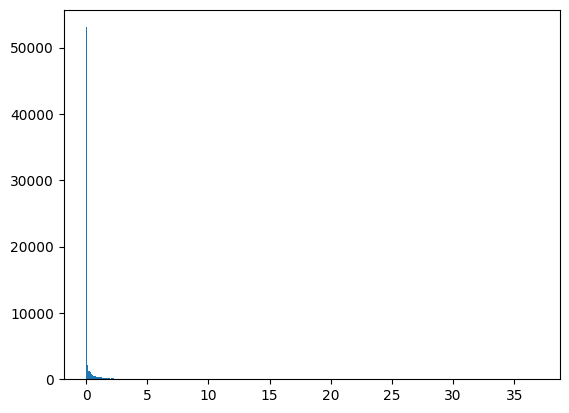

In [87]:
background_freq = background_freq / np.sum( background_freq )
q_mat = q_mat + q_mat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()

#ploT QMAT

plt.imshow(q_mat)
plt.colorbar()
plt.show()
plt.hist(q_mat.flatten() , bins = 400)
plt.show()


In [88]:
#normalize qmat so that each row and column sums to 1

for i in range(256):
    if np.sum( q_mat[i,:] ) > 0:
        q_mat[i,:] = q_mat[i,:] / np.sum( q_mat[i,:] )
        q_mat[:,i] = q_mat[i,:]
    else:
        q_mat[i,i] = 1
        q_mat[i,i] = 1

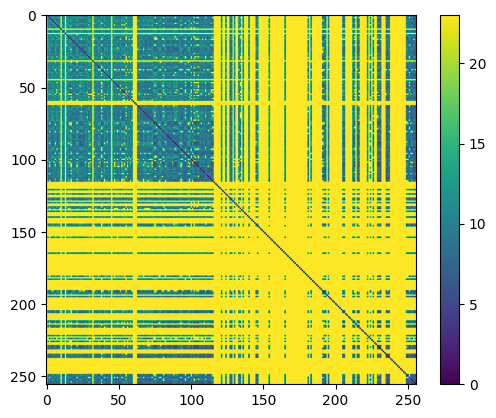

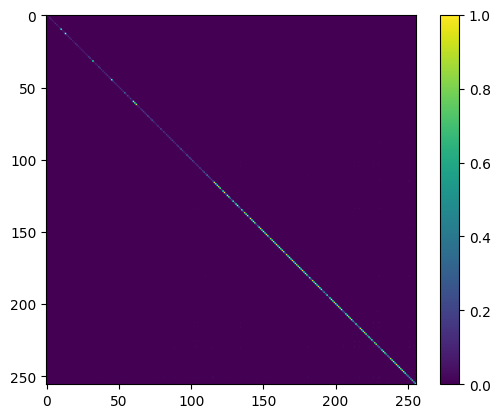

In [89]:
#divide the columns of qmat by the sum of the column

plt.imshow(-np.log(q_mat+10**-10))
plt.colorbar()
plt.show()


plt.imshow(q_mat)
plt.colorbar()
plt.show()

In [33]:
template_start = """
#NEXUS
BEGIN DATA;
  DIMENSIONS NTAX=4 NCHAR=8;
  FORMAT DATATYPE=STANDARD GAP=- SYMBOLS="Replace_w_alphabet";
  MATRIX
"""


template_end ="""
  ;
END;

"""
alphabet = ' '.join( [ chr(i) if chr(i) not in replace_dict else replace_dict[chr(i)] for i in range(1,249) ] )
#make a nexus file
matrix = {}
with open('fsx1_mafft.aln' , 'r') as g:
    for line in g:
        if line[0] == '>':
            ID = line[1:].strip()
            matrix[ID] = ''
        else:
            matrix[ID] += line.strip()

print( matrix )

with open('aln_nexus.nx' , 'w') as f:
    f.write( template_start.replace('Replace_w_alphabet' , alphabet )  )
    for ID, seq in matrix.items():
        f.write( ID + ' ' + seq + '\n' )
    f.write( template_end )

with open('aln_nexus.nx' , 'r') as f:
    for line in f:
        print( line )

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc3 in position 81: invalid continuation byte

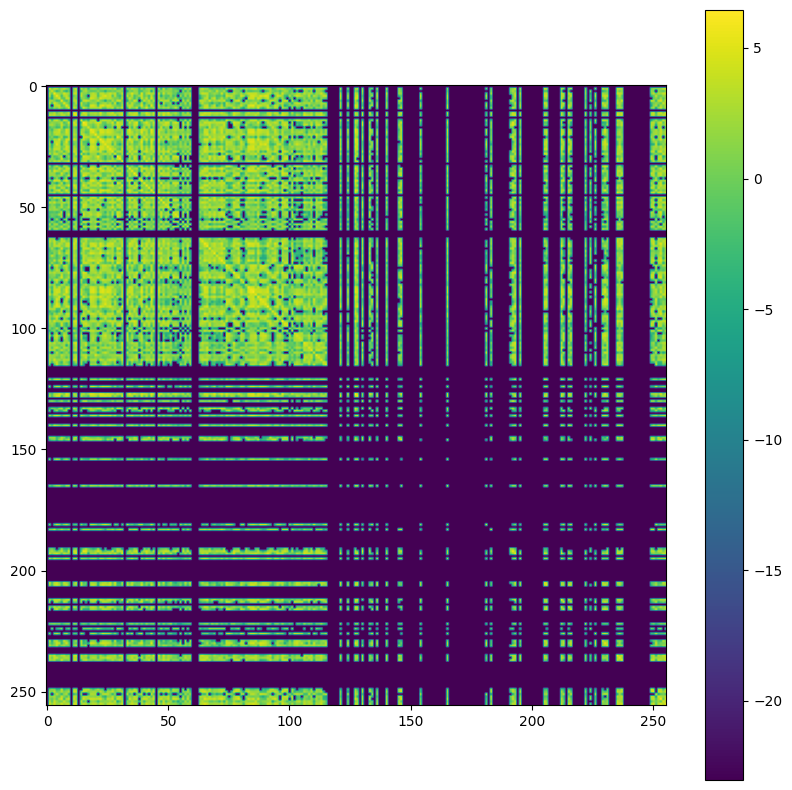

(array([44840.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,   680.,  1325.,  2154.,  3310.,
         4526.,  5626.,  2918.,   157.]),
 array([-23.02585093, -21.55189831, -20.07794569, -18.60399307,
        -17.13004045, -15.65608783, -14.18213521, -12.70818259,
        -11.23422997,  -9.76027736,  -8.28632474,  -6.81237212,
         -5.3384195 ,  -3.86446688,  -2.39051426,  -0.91656164,
          0.55739098,   2.0313436 ,   3.50529622,   4.97924884,
          6.45320146]),
 <BarContainer object of 20 artists>)

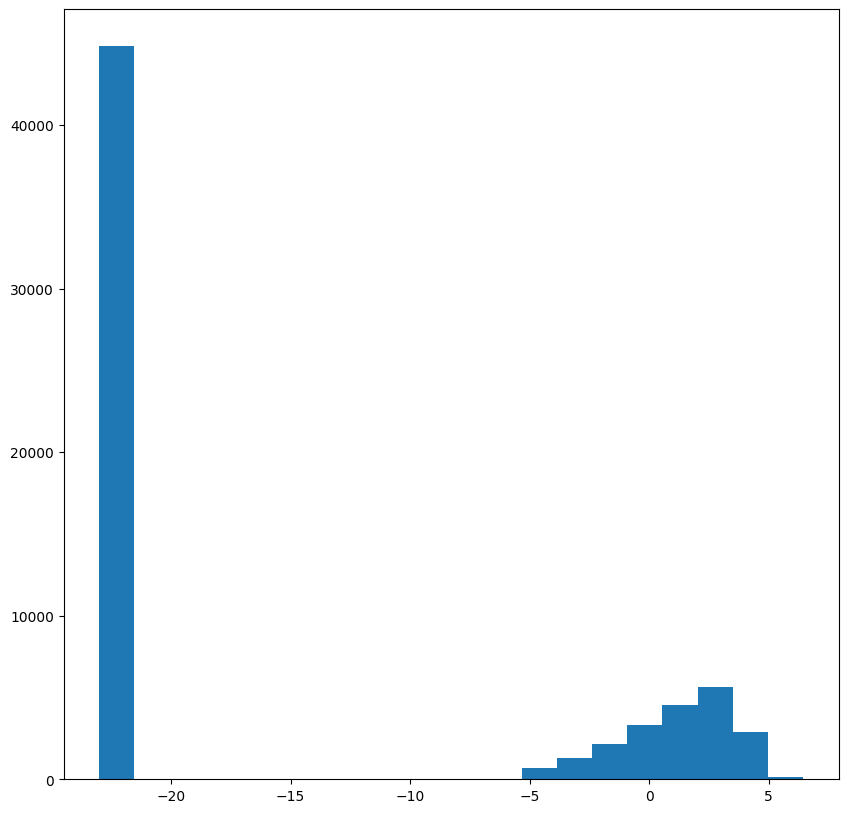

In [197]:
from matplotlib import pyplot as plt
plt.figure( figsize=(10,10))
plt.imshow(np.log(submat + 10**-10 ) )
plt.colorbar()

plt.show()
plt.figure( figsize=(10,10))

plt.hist( np.log( submat.flatten() + 10 **-10 )  , bins = 20)

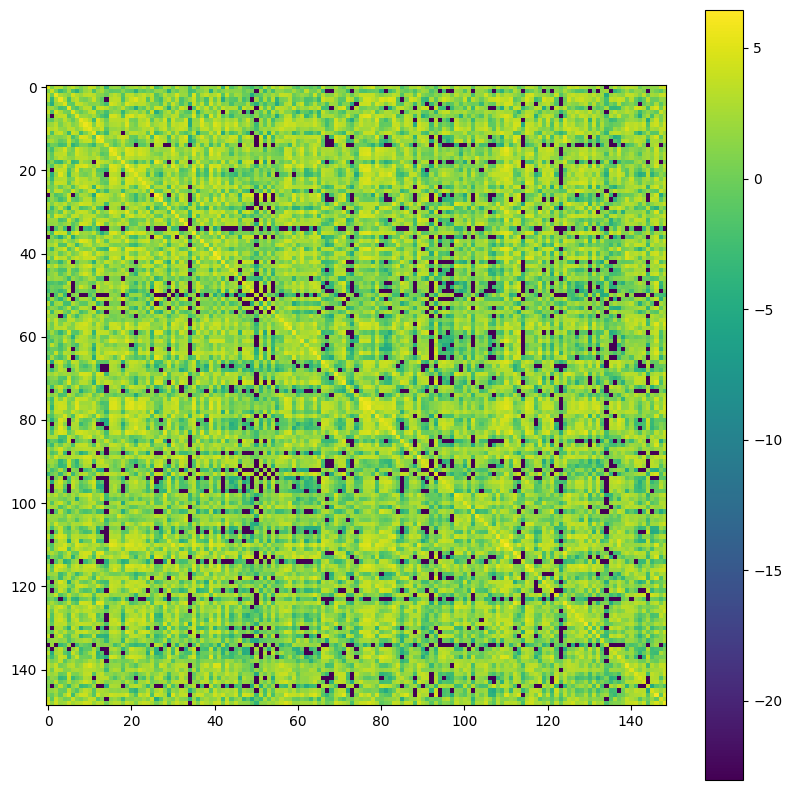

In [198]:
#remove zero rows and columns for visualization

vismat = submat[ np.sum(submat, axis=1) > 0 , : ]
vismat = vismat[ :, np.sum(vismat, axis=0) > 0 ]

plt.figure( figsize=(10,10))
plt.imshow(np.log(vismat + 10**-10 ) )
plt.colorbar()


In [38]:
#mafft matrix file example max 248 char
"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
    if len(hexnum) == 3:
        return hexnum[0:2] + '0' + hexnum[2]
    else:
        return hexnum

def output_mafft_matrix( submat , outpath='mafft_submat.mtx' ):
    with open(outpath, 'w') as f:
        for i in range(submat.shape[0]):
            for j in range(submat.shape[1]):
                if i <= j:
                    
                    stringi = chr(i)
                    stringj = chr(j)
                    
                    if stringi in replace_dict.keys():
                        stringi = replace_dict[stringi]
                    if stringj in replace_dict.keys():
                        stringj = replace_dict[stringj]
                    
                    i = ord(stringi)
                    j = ord(stringj)

                    hexi = formathex(hex(i))
                    hexj = formathex(hex(j))
                    
                    if submat[i,j] > 1:
                        f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
                    #else:
                    #    f.write( f'{hexi} {hexj} {0.0} # '+ stringi + 'x' + stringj + ' \n' )
output_mafft_matrix( submat , outpath='mafft_submat.mtx' )
with open('mafft_submat.mtx', 'r') as f:
    for line in f:
        print(line)

0x01 0x01 835.148830152395 

 0x01 0x02 14.35538363802962 

 0x01 0x03 172.91964755301635 

 0x01 0x04 135.2444060161928 

 0x01 0x05 8.982643118595547 

 0x01 0x06 68.58436929881647 

 0x01 0x07 260.9245632026139 

 0x01 0x08 36.58311402197155 

 0x01 0x09 7.4047174941761575 

 0x01 0xff 473.0925472955134 

 0x01 0x0b 52.64195629385981 

 0x01 0x0c 309.9456564590307 

 0x01 0xfe 216.39732376484403 

 0x01 0x0e 222.41984959498538 

 0x01 0x0f 7.8432900436609545 

 0x01 0x10 56.63210416726159 

 0x01 0x12 19.964359201895256 

 0x01 0x13 36.00900386910316 

 0x01 0x14 27.53845646412571 

 0x01 0x16 22.93128787112679 

 0x01 0x17 46.16536859032385 

 0x01 0x18 87.20871883557966 

 0x01 0x19 33.10772768708468 

 0x01 0x1a 103.75868556308853 

 0x01 0x1b 16.193813108580727 

 0x01 0x1c 309.3130007889195 

 0x01 0x1d 1.122477038672752 

 0x01 0x1e 2.6214715617817617 

 0x01 0x1f 116.03426293134123 

 0x01 0xfd 24.78038590827864 

 0x01 0x21 57.24582564290973 

 0x01 0x22 4.968586265838611 



In [161]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [159]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
    cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def mafft_hex2fasta( intext , outfasta ):
    #% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    


def fasta2hex( intext , outfasta ):
    #% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    

def run_iqtree_aln( infasta , outaln , matrix='iqtree_submat.mtx'  , thread=1   ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -nt 1
    cmd = f'iqtree -s {infasta} -m '+matrix+'+I+F -nt '+str(thread) 
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def run_iqtree_ancestral( infasta , outtree , matrix='iqtree_submat.mtx' ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr
    cmd = f'iqtree -s {infasta} -m ./iqtree_submat.mtx+I+F -t {outtree} -asr'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outtree

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def normal_iqtree( infasta  , thread=1 ):
    cmd = f'iqtree -s {infasta} -nt {thread} -m LG+F+I'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return None

def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [135]:


def run_iqtree_aln( infasta , outaln , matrix='iqtree_submat.mtx'  , thread=1   ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -nt 1
    cmd = f'iqtree -s {infasta} -m '+matrix+'+I+F -nt '+str(thread) 
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def run_iqtree_ancestral( infasta , outtree , matrix='iqtree_submat.mtx' ):
    #iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr
    cmd = f'iqtree -s {infasta} -m ./iqtree_submat.mtx+I+F -t {outtree} -asr'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outtree

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def normal_iqtree( infasta  , thread=1 ):
    cmd = f'iqtree -s {infasta} -nt {thread} -m LG+F+I'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return None

def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [136]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [71]:
#make normal fasta

with open( 'fsx1_example.fasta', 'w') as f:
    for s in structs:
        seq =  struct2sequence(s)
        identifier = s.split('/')[-1].split('.')[0]
        f.write('>' + identifier + '\n' + seq + '\n')


In [63]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )
#print aln

with open('fsx1_example.aln', 'r') as f:
    for line in f:
        print(line)


t = normal_iqtree( 'fsx1_example.aln')

mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
18 x 2364 - 0 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 18
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 18
done.

Progressive alignment 1/2... 
STEP    13 / 17 
Reallocating..done. *alloclen = 5806
STEP    17 / 17 
done.

Making a distance matrix from msa.. 
    0 / 18
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 18
done.

Progressive alignment 2/2... 
STEP    14 / 17 
Reallocating..done. *alloclen = 6035
STEP    16 / 17 

>6EGU

------------------------------CYSSERGLULEUILEGLNALASERSER-AR

GILETHRTHRCYSSERTHR------------------------------------THR--

----LY---------------SCYS-----ARGLEUSERGLY-------------THRA-

-LALEUILEA-------RGALAGLYSER------------VAL---GLYALA--------

-GLU---ALACYSLEUMETLEULYSGLYVALLYSGLUASPGL------NTHRLY------

---------------------------------------------------SPHELE---

---------------ULYSILELYS------------THRVALSERSERGLULEUSERCY

S------ARGGLUGLYGLNSERTYRTRPTHR---------GLYS----------------

-----------------ERPHESERPRO---LYS------------------CYSLEUSE

RSERARGARGCYSHISLEU---VALGLY----------------------------GLUC

YSHISVALASNAR----------GCY--------SLEUSERTRP------------ARGA

SPASNGLUTHRSERALA------------------------------GLUPHESERPHEV

ALGLYGLUSERT----------HRTHR------METAR---------GGLUASNLYSCYS

------------PHEGLUGLNCYS---------------------------GLY------

------------GLYHISGLYCYSGLYCYS------------------PHE---------

---------------------------A--------------------------------

-

STEP    17 / 17 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.

ERROR: Some sequences (see above) are problematic, please check your alignment again


In [158]:

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            yield data
        except:
            print('error')
            continue

loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


2it [00:01,  1.41it/s]

error


100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]
17it [00:11,  1.47it/s]


'fsx1_encoded.fasta'

In [155]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded.fasta'
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    with open('fsx1_encoded.hex' , 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line )
            else:
                hexstr = ''
                for char in line:
                    hexstr += formathex(hex(ord(char)))[2:] + ' '
                g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
    for line in f:
        print(line)

>6EGU

33 33 5c 40 10 6b 52 0c 5c 5c 01 6b 62 62 02 63 28 28 ed 02 06 10 5c eb 30 0c 10 6b 01 0c eb 1c 6a eb 0c 40 0c 02 10 31 10 ed eb 82 ed 40 b7 c3 30 56 70 c1 56 6b 56 30 6a 5c 5c 40 c1 1c de ff 23 eb c3 71 6c 6f 1a 2e 1c d4 1c 61 56 33 c1 1c 71 ff ff 46 ec 4d 29 2c fa 46 ec 6a 8c ff de 4d 71 6f ff 03 fe 40 30 32 0b 23 25 d7 25 29 2c 23 71 30 cd 5f ff fa 91 ed de 25 40 c3 de 2c 2c ec eb de 2c de 25 8c 82 8c 61 71 33 4d d4 6a 39 30 6c c1 c3 1c 6a ff 56 40 0c c1 ff 6a d4 fe 33 6b 03 6f 6a 39 56 c1 30 10 40 1f 30 2a 70 03 eb 71 6a 5c 30 6b 07 c1 eb 0c 1c 1c 1c 01 70 cd 91 6f eb 5c 6a 1c c1 1c c1 03 0c 40 2e 80 ce 2e ce 8c 71 d4 71 d4 1f 40 1c 4a eb 56 eb 6c 0c 1f 79 03 23 61 d4 71 23 1f 61 01 3b 2e d4 c1 2e 23 1f ff 33 fe 5c 40 71 71 6a c1 71 0c ec 23 71 33 c1 01 0c 61 fe c1 80 1c 6c 56 4a 5f 1f 07 3b c1 40 33 cd cd fe c1 80 07 61 d4 79 79 d4 40 01 0e 1c c1 4a 3b cd ff fe 07 56 cd 70 0c 0c 1c 56 0e fe 01 0e 6a 3b 0c 70 1c 56 eb 1c 6a 52 0c 07 10 30 c1 e7 70 2a 91 70 40 82 2a 70 6a eb 

In [160]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [163]:
#align wti mafft
run_mafft_textaln( asciifile , 'fsx1_econded.aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_econded.aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
Score(=0x1,=0x1)=835.148830
Score(=0x1,=0x2)=14.355384
Score(=0x1,=0x3)=172.919648
Score(=0x1,=0x4)=135.244406
Score(=0x1,=0x5)=8.982643
Score(=0x1,=0x6)=68.584369
Score(=0x1,=0x7)=260.924563
Score(=0x1=0x8)=36.583114
Score(=0x1,	=0x9)=7.404717
Score(=0x1,�=0xff)=473.092547
Score(=0x1,=0xb)=52.641956
Score(=0x1,=0xc)=309.945656
Score(=0x1,�=0xfe)=216.397324
Score(=0x1,=0xe)=222.419850
Score(=0x1,=0xf)=7.843290
Score(=0x1,=0x10)=56.632104
Score(=0x1,=0x12)=19.964359
Score(=0x1,=0x13)=36.009004
Score(=0x1,=0x14)=27.538456
Score(=0x1,=0x16)=22.931288
Score(=0x1,=0x17)=46.165369
Score(=0x1,=0x18)=87.208719
Score(=0x1,=0x19)=33.107728
Score(=0x1,=0x1a)=103.758686
Score(=0x1,=0x1b)=16.193813
Score(=0x1,=0x1c)=309.313001
Score(=0x1,=0x1d)=1.122477
Score(=0x1,=0x1e)=2.621472
Score(=0x1,=0x1f)=116.034263
Score(=0x1,�=0xfd)=24.780386
Score(=0x1,!=0x21)=57.245826
S

'fsx1_econded.aln.ascii'

In [164]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( 'fsx1_econded.aln.ascii' , 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_econded.aln.ascii > fsx1_encoded.aln.hex


In [165]:

with open( aln_hexfile , 'r') as f:
    for l in f:
        print(l)

>6EGU

33 -- -- -- 33 5c 40 10 6b 52 0c 5c 5c 01 6b 62 62 02 63 28 -- -- -- -- -- -- 28 ed 02 06 10 5c eb 30 0c 10 6b 01 0c -- -- -- -- -- -- -- -- -- eb 1c 6a eb -- -- -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 0c 40 0c 02 10 31 10 ed eb 82 ed 40 b7 c3 30 56 70 c1 56 6b 56 30 6a 5c 5c 40 c1 1c de ff 23 eb c3 71 6c 6f 1a 

2e 1c d4 1c 61 56 33 c1 1c 71 ff ff 46 ec 4d 29 2c fa 46 ec 6a 8c ff de 4d 71 6f ff 03 -- -- -- -- -- -- -- -- fe 40 30 32 0b 23 25 d7 25 29 2c 23 71 30 cd 5f -- -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- ff fa 91 ed de 25 40 c3 de 2c 2c ec eb de 2c de 25 8c 82 8c 61 71 33 4d d4 6a 39 30 6c c1 c3 1c 6a ff 56 40 0c c1 ff 6a d4 fe 

33 6b 03 6f 6a 39 56 c1 30 10 40 1f 30 -- -- -- 2a 70 03 eb 71 6a 5c -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 30 6b 07 c1 eb 0c 1c 1c 1c 01 

70 cd 91 6f eb 5c 6a 1c c1 1c c1 03 0c 40 2e 80 ce 2e ce 8c 71 d4 71 d4 1f 40 1c 4a

In [173]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
    seqdict = {}
    seqstr = ''
    ID = ''
    for line in f:
        if line[0] == '>':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line + ' '
    seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
6EGU                     33 -- -- -- 33 5c 40 10 6b 52 0c 5c 5c 01 6b 6...   
5mf1mono                 -- -- -- -- -- -- -- 6a 6a 6b 0c 5c eb 01 10 4...   
4GSX                     -- -- -- -- -- -- -- -- 01 01 02 82 eb bf 1e 9...   
WP_007110832_Naltunense  -- -- -- -- -- -- -- -- 6b c0 62 f9 6d 62 63 f...   
4OJC_model               -- -- -- -- -- -- -- -- -- -- -- 1e 1e 38 24 1...   
2ala                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
1OAN                     -- -- -- -- -- -- -- 5f 5f 06 33 6b eb 6b 5c 9...   
2I69                     -- -- -- -- -- -- -- 70 70 91 02 c1 eb e7 5c 9...   
6E18                     -- -- -- -- -- -- 40 40 6a 6b 0c 5c eb 01 10 4...   
WP_049937247_Hnatans     -- -- -- -- -- -- -- -- 0c 0c 0c 63 6d 4f 63 f...   
3n43                     eb -- -- -- -- -- -- -- -- -- -- -- -- 

In [ ]:
with open('fsx1_mafft.hex.aln', 'r') as f:
    with open('fsx1_mafft.aln', 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line)
                print(line)
            else:
                seq = ''
                for hexnum in line:
                    if hexnum == '-':
                        seq += '-'
                    elif hexnum != ' ' and hexnum != '\n':
                        seq += chr(int(hexnum,16))
                print(seq)
                g.write(seq + '\n')


In [ ]:

#make a tree with iqtree
run_iqtree_aln( 'fsx1_mafft.aln' , 'fsx1_iqtree' , matrix='iqtree_submat.mtx' )

In [ ]:

#save the submats in raw form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )

#normalize the submats rows and columns to sum to 1
for charset in charsets:
    rowsums = submats[charset].sum( axis=1 )
    colsums = submats[charset].sum( axis=0 )
    for i in range( charset ):
        submats[charset][i,:] = submats[charset][i,:] / rowsums[i]
        submats[charset][:,i] = submats[charset][:,i] / colsums[i]

#save the submats in normalized form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '_norm.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '_norm.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )
    



In [ ]:
#make tree
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F

#reconstruct
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr


In [ ]:
#pass the asr through the decoder to get ancestral AA sequences

#fold the amino acid asr and decoded asr into 3d structures using alphafold

#compare plddts
